# ✍🏻 Abstract  
  
**❖ 분석 과제**

- 고객 별 6개월 내, ‘대차’ 또는 ‘추가구매’ 가능성(Score)에 대한 예측모델 개발
  
  
**❖ 분석 방법 및 단계**  
- 예측모델 설계
> 1) 데이터 생성과 Feature Engineering  
> 2) 학습, 테스트 데이터 구분  
> 3) ML Modelling  
> 4) 예측 성능 평가  
> 5) 활용 방안  

## ✍🏻 3. 예측모델 설계

> ### Index.
> #### 1) 데이터 생성과 Feature Engineering
> #### 2) 학습, 테스트 데이터 구분
> #### 3) ML Modelling
> #### 4) 예측 성능 평가
> #### 5) 활용 방안

#### Library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="darkgrid")
from datetime import datetime

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/HANYGO230.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')
    
# 랜덤 시드 생성
np.random.seed(42)

#### 데이터 불러온 후 datetime 컬럼 타입 변환

In [2]:
data = pd.read_csv('final_data.csv')
df_car = pd.read_csv("'21년 해카톤_차량정보.csv",encoding='ansi') # 차량정보

data['WHOT_DT'] = pd.to_datetime(data['WHOT_DT'])
data['CAR_HLDG_STRT_DT'] = pd.to_datetime(data['CAR_HLDG_STRT_DT'])
data['CAR_HLDG_FNH_DT'] = pd.to_datetime(data['CAR_HLDG_FNH_DT'])

### 1) 데이터 생성과 Feature Engineering

In [3]:
final_df = data[:] # 데이터프레임 복사

# 보유종료일자 결측값을 데이터상 마지막일자 다음날인 '2018-01-01'로 채우기
final_df['CAR_HLDG_FNH_DT'].fillna('2018-01-01',inplace=True)
final_df['CAR_HLDG_FNH_DT'] = pd.to_datetime(final_df['CAR_HLDG_FNH_DT'])

# 차량 보유일 컬럼 결측치 제외하기 위해
final_df['own_days'] = final_df['CAR_HLDG_FNH_DT'] - final_df['CAR_HLDG_STRT_DT']
final_df['own_days'] = final_df['own_days'].apply(lambda x : float(str(x).split()[0]))

# 구매 년도 추출
final_df['Year'] = final_df['CAR_HLDG_STRT_DT'].apply(lambda x : x.year)
year_group = final_df.groupby('CUS_ID')['Year']

# 최초 구매한 년도 컬럼 생성
final_df['first_buy_year'] = year_group.transform(np.min)
# 가장 최근 구매한 년도 컬럼 생성
final_df['last_buy_year'] = year_group.transform(np.max)

In [4]:
# 고객 등급 컬럼 생성 (1~4등급)
final_df['cus_grade'] = 0

def func(x) :
    if x > 9 :
        return 4
    elif x > 6 and x <= 9 :
        return 3
    elif x > 3 and x <= 6:
        return 2
    else :
        return 1
    
final_df["cus_grade"] = final_df["total_buy_count"].apply(lambda x : func(x))

In [5]:
# 필요한 컬럼만 추출
final_df_ = final_df[['CUS_ID','PSN_BIZR_YN','SEX_SCN_NM','TYMD','total_buy_count','current_owner',
                      'current_own_count','cus_grade','first_buy_year','last_buy_year','target']]

# 유저별로 그룹화해 데이터프레임 재배열
final_df_ = final_df_.set_index('CUS_ID').groupby(level=0).first()

# 차량 평균 보유일수 컬럼 생성
own_days = final_df.groupby('CUS_ID')['own_days'].mean().to_frame()
final_df_ = pd.concat([final_df_,own_days],axis=1)

# 인덱스 제거
final_df_.reset_index(inplace=True)

#### 최종 data 완성

In [6]:
# 데이터 완성
final_df_

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,AONEEOO010000113,0,1,1955,2,True,1,1,2006,2011,대차,1362.5
1,AONEEOO020000165,1,1,1951,2,True,2,1,2005,2010,추가구매,3804.5
2,AONEEOO020000170,0,1,1952,2,True,1,1,2001,2012,대차,2834.0
3,AONEEOO020000290,1,1,1960,2,True,1,1,2010,2017,대차,349.0
4,AONEEOO040000233,1,1,1953,2,True,1,1,2006,2009,대차,3540.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1096201,ATZZZZV310001224,0,1,1980,1,False,0,1,2000,2000,대차,2736.0
1096202,ATZZZZV310001226,0,0,1980,1,False,0,1,2008,2008,대차,2783.0
1096203,ATZZZZV310001228,0,1,1981,2,False,0,1,2000,2002,대차,1739.0
1096204,ATZZZZV310001232,0,1,1985,2,False,0,1,2000,2012,대차,1888.5


#### 최종 데이터 생성 완료 
- 1096206 rows × 12 columns
- 고객의 주소와 주택 관련 컬럼은 결측치가 너무 많아 학습데이터에서 제외
>  - 컬럼설명
 1. 'CUS_ID' : 고객ID (1,096,206 명)
 2. 'PSN_BIZR_YN' : 사업자여부 (1:사업자, 0:비사업자)
 3. 'SEX_SCN_NM' : 성별 (1:남자, 0:여자)
 4. 'TYMD' : 출생년도
 5. 'total_buy_count' : 차량을 총 몇 번 구매했는지 (1번 ~ 12번)
 6. 'current_owner' : 현재 차량을 보유 중인지 (bool타입 T/F)
 7. 'current_own_count' : 현재 몇 대를 보유 중인지 (1대 ~ 12대)
 8. 'cus_grade' : 고객별 등급 (우량고객 관리 차원)  
         - 구매횟수가 1~3번이면 "브론즈등급(1)"
         - 구매횟수가 4~6번이면 "실버등급(2)"
         - 구매횟수가 7~9번이면 "골드등급(3)"
         - 구매횟수가 10~12번이면 "플래티넘등급(4)"
 9. 'first_buy_year' : 고객 별 첫 구매 년도 (2000년 ~ 2017년)
 10. 'last_buy_year' : 고객 별 가장 최근 구매 년도 (2000년 ~ 2017년)
 11. 'own_days' : 고객 별 평균 차량 보유일수 (보유종료시점-보유시작시점)
 12. **'target' : 재구매 유형 (대차/추가구매) , 정답 데이터**

### 2) train, test data 구분
test data
> - 65610 rows × 12 columns
> - 데이터상 과거 6개월 내(2017-06-01 ~ 2017-12-31)에 구매기록이 있는 고객
> - **65,610명의 고객에 대한 재구매 유형 예측 진행**  

train data
> - 1,030,596 rows × 12 columns
> - 전체 데이터 1,096,206명 중 test data를 제외한 고객

#### test 및 train 데이터 생성

In [7]:
# 'WHOT_DT' 컬럼 데이트타임으로 변환
df_car['WHOT_DT'] = df_car['WHOT_DT'].apply(lambda x : str(x)[:4] + '/' + str(x)[4:6] + '/' + str(x)[6:])
df_car['WHOT_DT'] = pd.to_datetime(df_car['WHOT_DT'])

# 데이터상 과거 6개월 내 구매기록이 있는 유저만 추출
df_test = df_car[df_car['WHOT_DT']>'2017-05-31']['CUS_ID'].value_counts().to_frame()
df_test.reset_index(inplace=True)
df_test = df_test.drop('CUS_ID',axis=1).rename(columns={'index':'CUS_ID'})
test = pd.merge(df_test, final_df_, on='CUS_ID')

# test 데이터를 제외한 데이터를 train에 저장
train = pd.concat([final_df_,test], axis=0).drop_duplicates(['CUS_ID'], keep = False)

In [8]:
display(train.head(3), test.head(3))

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,AONEEOO010000113,0,1,1955,2,True,1,1,2006,2011,대차,1362.5
1,AONEEOO020000165,1,1,1951,2,True,2,1,2005,2010,추가구매,3804.5
2,AONEEOO020000170,0,1,1952,2,True,1,1,2001,2012,대차,2834.0


,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,ATZOPZT280000341,1,1,1974,11,True,4,4,2017,2017,추가구매,122.454545
1,ATZOPZH170000759,1,1,1981,4,True,4,2,2017,2017,추가구매,185.500000
2,AONNHOT270000414,1,0,1950,4,True,3,2,2012,2017,추가구매,477.500000


#### Label Encoding 
- 머신러닝 모델은 숫자형 변수만 취급하기 때문에 문자형 컬럼을 숫자형으로 바꿔주는 레이블 인코딩 진행
- 'CUS_ID', 'target' 컬럼 레이블 인코딩 진행

In [9]:
# 문자형 컬럼 Label Encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

train['target'] = le.fit_transform(train['target'])
train['CUS_ID'] = le.fit_transform(train['CUS_ID'])

test['target'] = le.fit_transform(test['target'])
test['CUS_ID'] = le.fit_transform(test['CUS_ID'])

In [10]:
display(train.head(3), test.head(3))

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,0,0,1,1955,2,True,1,1,2006,2011,0,1362.5
1,1,1,1,1951,2,True,2,1,2005,2010,1,3804.5
2,2,0,1,1952,2,True,1,1,2001,2012,0,2834.0


,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,21328,1,1,1974,11,True,4,4,2017,2017,1,122.454545
1,15668,1,1,1981,4,True,4,2,2017,2017,1,185.500000
2,678,1,0,1950,4,True,3,2,2012,2017,1,477.500000


#### MinMaxScaler
- 모델이 학습하기에 편하도록 숫자형 컬럼 중 단위가 큰 컬럼을 '0 과 1' 사이의 수로 치환해줌.
- 종류가 100만개가 넘는 'CUS_ID' 컬럼 스케일링 진행

In [11]:
train[['CUS_ID']] = preprocessing.MinMaxScaler().fit(train[['CUS_ID']]).transform(train[['CUS_ID']])
test[['CUS_ID']] = preprocessing.MinMaxScaler().fit(test[['CUS_ID']]).transform(test[['CUS_ID']])

In [12]:
display(train.head(3), test.head(3))

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,0.000000e+00,0,1,1955,2,True,1,1,2006,2011,0,1362.5
1,9.703133e-07,1,1,1951,2,True,2,1,2005,2010,1,3804.5
2,1.940627e-06,0,1,1952,2,True,1,1,2001,2012,0,2834.0


,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,0.325077,1,1,1974,11,True,4,4,2017,2017,1,122.454545
1,0.238809,1,1,1981,4,True,4,2,2017,2017,1,185.500000
2,0.010334,1,0,1950,4,True,3,2,2012,2017,1,477.500000


#### train, test data 완성

In [13]:
display(train, test)

,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,0.000000e+00,0,1,1955,2,True,1,1,2006,2011,0,1362.5
1,9.703133e-07,1,1,1951,2,True,2,1,2005,2010,1,3804.5
2,1.940627e-06,0,1,1952,2,True,1,1,2001,2012,0,2834.0
3,2.910940e-06,1,1,1960,2,True,1,1,2010,2017,0,349.0
4,3.881253e-06,1,1,1953,2,True,1,1,2006,2009,0,3540.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1096201,9.999961e-01,0,1,1980,1,False,0,1,2000,2000,0,2736.0
1096202,9.999971e-01,0,0,1980,1,False,0,1,2008,2008,0,2783.0
1096203,9.999981e-01,0,1,1981,2,False,0,1,2000,2002,0,1739.0
1096204,9.999990e-01,0,1,1985,2,False,0,1,2000,2012,0,1888.5


,CUS_ID,PSN_BIZR_YN,SEX_SCN_NM,TYMD,total_buy_count,current_owner,current_own_count,cus_grade,first_buy_year,last_buy_year,target,own_days
0,0.325077,1,1,1974,11,True,4,4,2017,2017,1,122.454545
1,0.238809,1,1,1981,4,True,4,2,2017,2017,1,185.500000
2,0.010334,1,0,1950,4,True,3,2,2012,2017,1,477.500000
3,0.383865,1,0,1978,3,True,3,1,2017,2017,1,32.000000
4,0.030788,1,1,1964,12,True,8,4,2000,2017,1,1547.833333
...,...,...,...,...,...,...,...,...,...,...,...,...
65605,0.180356,0,0,1993,1,True,1,1,2017,2017,0,5.000000
65606,0.672225,1,1,1965,2,True,1,1,2004,2017,0,1121.000000
65607,0.155131,0,0,1965,1,True,1,1,2017,2017,0,35.000000
65608,0.819019,0,0,1957,2,True,1,1,2002,2017,0,1383.500000


#### 변수간 상관관계 확인
- 정답컬럼과 높은 상관관계를 보이는 컬럼 : current_own_count(0.64), total_buy_count(0.41)
- 이진분류이기 때문에 상관관계가 크게 의미 있어 보이진 않음

Text(0.5, 1, 'Feature Correlation')

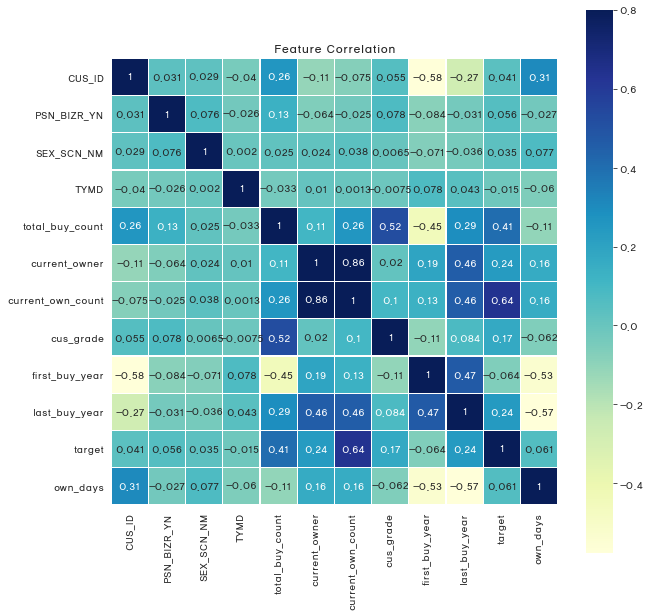

In [14]:
corr = train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu')
plt.title('Feature Correlation')

#### 정답 데이터 분리
- **대차 : 0**
- **추가구매 : 1**

In [15]:
# 학습, 정답 데이터 분리
y = train[['target']]
X = train.drop('target',axis=1)

y_test = test[['target']]
X_test = test.drop('target',axis=1)

### 3) ML Modelling
> - 모델은 트리계열의 부스팅 알고리즘인 **LightGBM** 사용
> - 모델의 정확도를 높이기 위한 **StratifiedKFold**를 통한 교차검증 사용
> - 모델 성능 개선을 위한 **파라미터** 조절

!pip install lightgbm

In [16]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# k값은 5로 교차검증 실행
num_split = 5
kf = StratifiedKFold(n_splits=num_split, shuffle=True)
y_pred = 0

for train_index, val_index in kf.split(X,y):                # cross validation
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # LGBM 모델 파라미터 조절
    params = {}
    params['learning_rate'] = 0.003
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = 10
    params['min_data'] = 50
    params['max_depth'] = 10

    train_ds = lgb.Dataset(X_train, label=y_train) 
    valid_ds = lgb.Dataset(X_val, label=y_val) 
    
    # 학습 및 검증
    model = lgb.train(params, train_ds, 1000, valid_ds, verbose_eval=10, early_stopping_rounds=100) 
    
    # 테스트 데이터 예측
    y_pred += model.predict(X_test) / num_split 

[LightGBM] [Info] Number of positive: 89967, number of negative: 734509
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 824476, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109120 -> initscore=-2.099759
[LightGBM] [Info] Start training from score -2.099759
Training until validation scores don't improve for 100 rounds
[10]	valid_0's binary_logloss: 0.330931
[20]	valid_0's binary_logloss: 0.3176
[30]	valid_0's binary_logloss: 0.302092
[40]	valid_0's binary_logloss: 0.290721
[50]	valid_0's binary_logloss: 0.276755
[60]	valid_0's binary_logloss: 0.265681
[70]	valid_0's binary_logloss: 0.256782
[80]	valid_0's binary_logloss: 0.248664
[90]	valid_0's binary_logloss: 0.239294
[100]	valid_0's bi

[680]	valid_0's binary_logloss: 0.0629047
[690]	valid_0's binary_logloss: 0.0618857
[700]	valid_0's binary_logloss: 0.0607833
[710]	valid_0's binary_logloss: 0.0599967
[720]	valid_0's binary_logloss: 0.059102
[730]	valid_0's binary_logloss: 0.0582768
[740]	valid_0's binary_logloss: 0.057471
[750]	valid_0's binary_logloss: 0.0564419
[760]	valid_0's binary_logloss: 0.0555236
[770]	valid_0's binary_logloss: 0.0547898
[780]	valid_0's binary_logloss: 0.0540363
[790]	valid_0's binary_logloss: 0.0531686
[800]	valid_0's binary_logloss: 0.0523907
[810]	valid_0's binary_logloss: 0.0516455
[820]	valid_0's binary_logloss: 0.0507057
[830]	valid_0's binary_logloss: 0.049905
[840]	valid_0's binary_logloss: 0.0488704
[850]	valid_0's binary_logloss: 0.0480753
[860]	valid_0's binary_logloss: 0.0472468
[870]	valid_0's binary_logloss: 0.0466419
[880]	valid_0's binary_logloss: 0.046102
[890]	valid_0's binary_logloss: 0.0453343
[900]	valid_0's binary_logloss: 0.0447601
[910]	valid_0's binary_logloss: 0.0442

[320]	valid_0's binary_logloss: 0.127953
[330]	valid_0's binary_logloss: 0.12446
[340]	valid_0's binary_logloss: 0.120971
[350]	valid_0's binary_logloss: 0.118079
[360]	valid_0's binary_logloss: 0.11507
[370]	valid_0's binary_logloss: 0.112446
[380]	valid_0's binary_logloss: 0.110346
[390]	valid_0's binary_logloss: 0.108131
[400]	valid_0's binary_logloss: 0.105981
[410]	valid_0's binary_logloss: 0.103631
[420]	valid_0's binary_logloss: 0.101461
[430]	valid_0's binary_logloss: 0.0993026
[440]	valid_0's binary_logloss: 0.0972334
[450]	valid_0's binary_logloss: 0.0955614
[460]	valid_0's binary_logloss: 0.0936934
[470]	valid_0's binary_logloss: 0.0920219
[480]	valid_0's binary_logloss: 0.0902451
[490]	valid_0's binary_logloss: 0.0884883
[500]	valid_0's binary_logloss: 0.0873402
[510]	valid_0's binary_logloss: 0.0854736
[520]	valid_0's binary_logloss: 0.0839488
[530]	valid_0's binary_logloss: 0.082442
[540]	valid_0's binary_logloss: 0.0809768
[550]	valid_0's binary_logloss: 0.0796314
[560]	

### 4) 예측 성능 평가
>#### (1) 평가지표 선정
        > - confusion_matrix (혼동행렬)  
        > - accuracy (정확도)
        > - precision (정밀도)
        > - recall (재현율)
        > - f1 score (F1 점수)

In [17]:
# 임계치 설정해서 정답컬럼 0과 1로 분류
#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=.5:       # setting threshold to 0.5
        y_pred[i]=1
    else:
        y_pred[i]=0

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

# report
report = classification_report(y_test, y_pred)

# Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy=accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

#### (1) 평가지표 출력
#### - 혼동행렬 (confusion matrix)
- TP : 1이라고 예측했는데, 실제로도 1인 경우 (정답)
- TN : 0이라고 예측했는데, 실제로도 0인 경우 (정답)
- FP : 1이라고 예측했으나, 실제로는 0인 경우 (오답)
- FN : 0이라고 예측했으나, 실제로는 1인 경우 (오답)

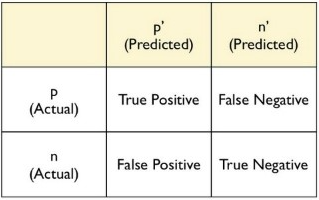

#### - 정확도 (accuracy)
- 정확도 = 전체 중 올바르게 예측한 것을 나타내는 지표
- (TP + TN) / (TP + TN + FP + FN)

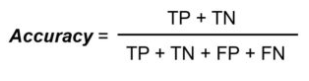

#### - 정밀도 (precision)
- 정밀도 = 모델의 예측값이 얼마나 정확하게 예측됐는가를 나타내는 지표 
- TP / (TP+FP)

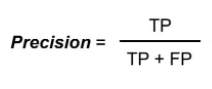

#### - 재현율 (recall)
- 재현율 = 실제값 중에서 모델이 검출한 실제값의 비율을 나타내는 지표   
- TP / (TP+FN)

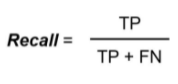

#### - F1 점수 (F1-score)
- F1 점수 = 이 두값 조화평균내서 하나의 수치로 나타낸 지표
- (2 * 재현율 * 정밀도) / (재현율+정밀도)

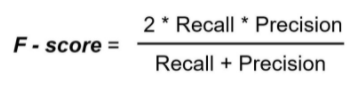

In [18]:
print('혼동행렬')
print(cm)
print('-'*60)
print('정밀도 : ',precision)
print('-'*60)
print('재현율 : ',recall)
print('-'*60)
print('F1 score : ',f1_score)
print('-'*60)
print('정확도 : ',accuracy)
print('-'*60)
print('REPORT')
print(report)

혼동행렬
[[45235   215]
 [  390 19770]]
------------------------------------------------------------
정밀도 :  0.9892419314485864
------------------------------------------------------------
재현율 :  0.9806547619047619
------------------------------------------------------------
F1 score :  0.9849296300909203
------------------------------------------------------------
정확도 :  0.9907788446883097
------------------------------------------------------------
REPORT
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     45450
           1       0.99      0.98      0.98     20160

    accuracy                           0.99     65610
   macro avg       0.99      0.99      0.99     65610
weighted avg       0.99      0.99      0.99     65610



- precision : 0.9892430079551708
- recall : 0.9807539682539682
- f1-score : 0.9849801977731836
- accuracy : 0.9908093278463649

#### (2) 변수의 중요도 추출
- 중요도가 가장 높게 나타난 변수는 **'own_days'(고객 별 평균 차량 보유일)**
- 해당 변수들을 토대로 재구매 유형을 분리하는 기준을 세울 수 있음

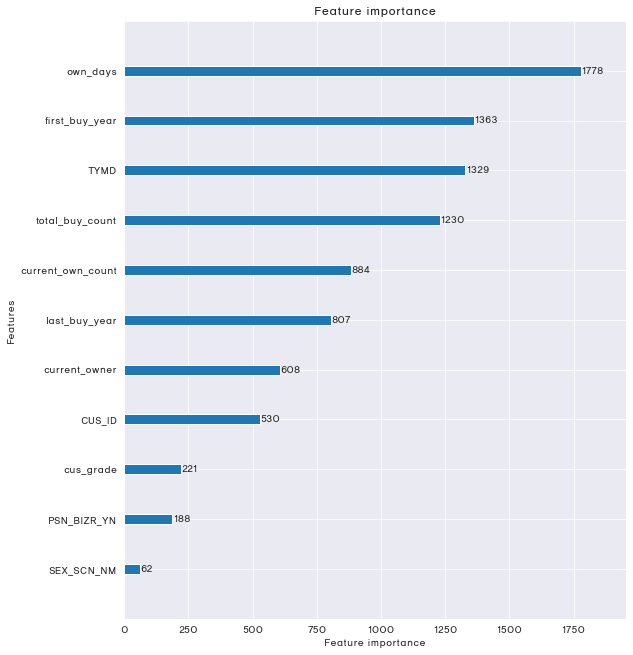

In [19]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(9,11))
plot_importance(model, ax=ax)
plt.savefig('변수의 중요도.png')

#### (3) 예측값과 원래값 비교
- 대차 : 0
- 추가구매 : 1

In [20]:
comparison = pd.DataFrame({'prediction': y_pred,
                          'ground_truth' : y_test.values.ravel()}) 
comparison

,prediction,ground_truth
0,1.0,1
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1
...,...,...
65605,0.0,0
65606,0.0,0
65607,0.0,0
65608,0.0,0


In [21]:
# 실제값과 예측값 비교
print('실제 값')
print(comparison['ground_truth'].value_counts())
print()
print('예측 값')
print(comparison['prediction'].value_counts())

실제 값
0    45450
1    20160
Name: ground_truth, dtype: int64

예측 값
0.0    45625
1.0    19985
Name: prediction, dtype: int64


### 5) 활용 방안

#### - 재구매 유도를 위한 개인화 마케팅 시, 고객들을 대차와 추가구매 두 유형으로 나눠 새로운 액션플랜을 도출할 수 있다.
> #### 1) 두 유형에서 보이는 연령대의 특징을 이용해, “연령 별 개인화 마케팅”을 실시한다.  
> #### 2) 대차 고객들의 리텐션을 추가구매 고객들만큼 끌어올리기 위해,  구매횟수를 기준으로 고객 별 등급을 만들어 “브랜드 로열티”를 높인다.   
> #### 3) 데이터 상 현재 현대차를 보유하고 있지 않은 고객들도 상당수 존재하므로, 이들을 “컴백시키기 위한 마케팅 전략” 또한 필요해 보인다.  
#### - 또한, 이미 훈련이 이뤄진 모델이기 때문에, 차후에 데이터를 추가해 재사용할 수 있다. 최근 데이터를 기반으로 예측 업데이트를 주기적으로 자동화한다.

이미지 출처
- 평가지표 이미지 : https://keytodatascience.com/confusion-matrix/